In [1]:
"""
Pidgin is a literate computing implementation in IPython.  It allows authors to compose their source in the markup language of their choice (e.g. Markdown, RST, Latex).  Narrative, source code, and documentation tests are composed together.

"""

'\nPidgin is a literate computing implementation in IPython.  It allows authors to compose their source in the markup language of their choice (e.g. Markdown, RST, Latex).  Narrative, source code, and documentation tests are composed together.\n\n'

In [2]:
    __all__ = 'PidginLoader',

In [3]:
    _run_as_main =  __name__ == '__main__'
    _run_as_script = _run_as_main and globals().get('__file__', None) in __import__('sys').argv
    _run_as_interactive = _run_as_main and not _run_as_script    

In [4]:
    import ast, textwrap, re, doctest, functools, collections, contextlib, sys
    import pandocfilters, ipykernel.zmqshell, ipykernel.kernelapp, traitlets, IPython, nbconvert, jinja2.meta, jinja2.ext
    import importnb, htmlmin
    
    get_ipython = IPython.get_ipython
    shell = get_ipython()

    pidgin=\
    0 and _run_as_interactive and __import__('pidgin').load()

In [5]:
    shell = get_ipython()

In [6]:
    input_formats = !pandoc --list-input-formats
    output_formats = !pandoc --list-output-formats    

    def translate(source=None, input='markdown', target='rst', file=None, args='', *, lang='ipython'):
        if callable(target): return target(source)
        import json, subprocess
        process = subprocess.Popen([
            'pandoc', 
            f'''--read={input}{args}''', 
            f'--write={target}', *F"--indented-code-classes={lang}".rstrip().split()], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
        returns = process.communicate(source.encode())[0].decode()
        if target in {'json'}: return json.loads(returns)
        return returns

In [7]:
    def python(source, input='markdown'):
        if should_not_transform_source(source): return source
        def action(type, value, format, metadata):
            nonlocal code, remaining, min_indent
            if type == 'CodeBlock':
                if (''.join(value[0][1]) or 'ipython') == 'ipython' and (
                    not value[1].lstrip().startswith('>>>')
                ):
                    splitter = re.compile(''.join("\\s{0,4}%s\\s*"%re.escape(x) for x in value[1].splitlines() if x.strip()))

                    try: before, after = re.split(splitter, remaining, 1)
                    except:  before = after = ''
                    current = len(after) and remaining[len(before):-len(after)] or remaining[len(before):]
                    if current.lstrip().startswith('```'): return
                    remaining = after

                    # Extract the first line of the current code block.
                    first_line = get_first_line(current)
                    # Construct the code we'll 
                    current, body = ''.join(current), ''.join(before)

                    # The previous last line append
                    last_line = get_last_line(code.splitlines())

                    if not last_line.endswith(('"'*3, "'"*3, '-'*3, '"'*3+"\\", "'"*3+'\\',)): body = quote(body)

                    definition = last_line.rstrip().endswith(':')

                    this_indent = get_line_indent(first_line)                  
                    min_indent = min_indent or this_indent

                    # The current indent level so far.
                    prior_indent = get_line_indent(last_line) or min_indent

                    if this_indent < min_indent:
                        current = textwrap.indent(current, ' '*(min_indent-this_indent))
                        this_indent = get_line_indent(get_first_line(current.splitlines()))

                    indent = max(min_indent, (has_return(code) and min or max)(prior_indent, this_indent))        
                    if definition:
                        if prior_indent >= indent: indent = (prior_indent + 4)
                        body = hanging_indent(textwrap.indent(body, ' '*min_indent), ' '*(indent-min_indent))
                    else: body = textwrap.indent(body, ' '*indent)

                    code += body+current
                    
        remaining, code, min_indent = source, """""", 0
        pandocfilters.walk(translate(source, input, 'json'), action, 'python', {})
        if remaining.strip(): code += textwrap.indent(quote(remaining), ' '*min_indent).rstrip() + ';'
        return textwrap.dedent(code)

    def remove_doctest_cleanup(input_transformer_manager):  
        for i, transformer in enumerate(input_transformer_manager.cleanup_transforms):
            try:
                if transformer.initial_re.pattern[1:4] == '>>>': input_transformer_manager.cleanup_transforms.pop(i); break
            except: ...

    def quote(str: str) -> str:
        if not str.strip(): return str
        str, leading_ws = ''.join(str), []
        lines = str.splitlines(True)
        while lines and (not lines[0].strip()): leading_ws.append(lines.pop(0))    
        str = ''.join(lines)
        end = len(str.rstrip())
        str, ending_ws = str[:end], str[end:]
        
        _ = '"'*3
        if str.startswith(('"'*3, "'"*3)) and str.endswith(('"'*3, "'"*3)): _ = ""
        elif _ in str: _ = "'"*3
        
        if str and str.endswith(("'", '"')): str += ' '                    
        return F"{''.join(leading_ws)}{_}{str}{_}{ending_ws}"


    def get_first_line(lines: (str, list), line: str='') -> str:
        if not isinstance(lines, (reversed, list)): lines = lines.splitlines()
        for line in lines or ['']: 
            if line.strip(): break
        return line

    def get_last_line(lines, line=''): return get_first_line(lines[::-1], line)

    def get_line_indent(line: str) -> int:   return len(line) - len(line.lstrip())

    def has_return(code: str) -> bool:
        code = '\n'.join(code)
        if 'return ' not in code: return False
        code = importnb.loader.dedent(code)
        try:
            node = ast.parse(code)
            while hasattr(node, 'body'): node = node.body[-1]
            return isinstance(node, ast.Return)
        except: ...

    def hanging_indent(str, indent: str, *, out="""""") -> str:
        for line in str.splitlines(True):
            if not line.strip(): out += line
            else:
                if out.strip(): out += line
                else: out += indent+line
        return out
    
    def strip_blank_lines(str): return '\n'.join(str if str.strip() else '' for str in ''.join(str).splitlines())

    def should_not_transform_source(str): return str.startswith('%%')    

In [8]:
    class Shell(traitlets.HasTraits):
        """
what

        """
        input = traitlets.Enum(input_formats, 'markdown')
        enabled = traitlets.Bool(False, help="""""", allow_none=True)
        
        @traitlets.observe('enabled')
        def _observe_enabled(self, change=None): 
            if self.is_ipython_extension(): 
                self.load_ipython_extension(self.parent) if change['new'] else self.unload_ipython_extension(self.parent) 
#             self.parent.display_formatter.mimebundle_formatter.enabled = self.parent.display_formatter.ipython_display_formatter.enabled = True
#             for type in self.parent.display_formatter.active_types: self.parent.display_formatter.formatters[type].enabled=True
            
        
        parent = traitlets.Instance(IPython.InteractiveShell, allow_none=True)
        
        @traitlets.default('parent')
        def _default_parent(self): return IPython.get_ipython()

        def _wrap_enabled(self, callable):
            def wraps(*a): self.enabled and callable(*a)
            return functools.wraps(callable)(wraps)
            
        def is_ipython_extension(self): return hasattr(self, 'load_ipython_extension') and self.enabled
        
        def triggers(self): return list(object for object in IPython.core.events.available_events if hasattr(self, object))
        
        def __init__(self, **kwargs):
            traitlets.HasTraits.__init__(self, **kwargs), self.parent
            self.is_ipython_extension() and self.load_ipython_extension(self.parent)
            for trigger in self.triggers(): self.parent.events.register(trigger, self._wrap_enabled(getattr(self, trigger)))

In [9]:
    class Tangle(Shell, traitlets.config.SingletonConfigurable):
        
        def translate(self, source, target): return target(source) if callable(target) else translate(source, self.input, target, args="-footnotes")
        python = functools.partialmethod(translate, target=python)
    
        def __call__(self, lines):  return self.python(''.join(lines)).splitlines(True) if self.enabled else lines
        
        def load_ipython_extension(self, shell): remove_doctest_cleanup(shell.input_transformer_manager), shell.input_transformer_manager.cleanup_transforms.insert(0, self)
            
        def unload_ipython_extension(self, shell): shell.input_transformer_manager.cleanup_transforms = [object for object in shell.input_transformer_manager.cleanup_transforms if not isinstance(object, Tangle)]
            

    [setattr(Tangle, object, functools.partialmethod(Tangle.translate, target=object)) for object in input_formats];
    

In [10]:
    @IPython.core.magics.magics_class
    class TangleMagic(IPython.core.magics.Magics):
        @IPython.core.magic.cell_magic
        def tangle(self, line, cell):
            import black
            enabled = Tangle.instance().enabled
            Tangle.instance().enabled = True
            cell = self.shell.input_transformer_manager.transform_cell(cell)
            IPython.display.display(IPython.display.Code(cell, language='python'))
            IPython.display.display(
                    IPython.display.Code(
                        black.format_str(ast.dump(self.shell.transform_ast(self.shell.compile.ast_parse(cell))), mode=black.FileMode())))

            Tangle.instance().enabled = enabled
            
    Tangle.instance().parent.register_magics(TangleMagic(Tangle.instance().parent))

In [11]:
    class Doctest(Shell, traitlets.config.SingletonConfigurable):
        def post_run_cell(self, result, *a, **kwargs): return run_docstring_examples(result.info.raw_cell, self.parent)
        
    class InlineOutputCheck(doctest.OutputChecker):
        def check_output(self, *e): return True

    def run_docstring_examples(str, shell=shell, verbose=False, compileflags=None):
        runner = doctest.DocTestRunner(verbose=verbose, optionflags=doctest.ELLIPSIS)
        globs = shell.user_ns;
        with wrapped_compiler(shell):
            for test in doctest.DocTestFinder(verbose).find(str, name=shell.user_module.__name__): test.globs = globs;  runner.run(test, compileflags=compileflags, clear_globs=False)
            
        runner._checker = InlineOutputCheck()
        with wrapped_compiler(shell):
            for test in doctest.DocTestFinder(verbose, InlineDoctestParser()).find(str, name=shell.user_module.__name__): test.globs = globs;  runner.run(test, compileflags=compileflags, clear_globs=False)
        return runner

    @contextlib.contextmanager
    def wrapped_compiler(shell):
        def compiler(input, filename, symbol, *args, **kwargs):
            nonlocal shell
            return shell.compile(ast.Interactive(body=shell.transform_ast(shell.compile.ast_parse(shell.transform_cell(textwrap.indent(input, ' '*4)))).body), filename, 'single' )
        yield setattr(doctest, 'compile', compiler)
        try: doctest.compile = compile
        except: ...

    class InlineDoctestParser(doctest.DocTestParser):
        _tick_ = "`"    
        _EXAMPLE_RE = re.compile(_tick_+"(?P<indent>)(?P<source>.*?)"+_tick_)
            
        def _parse_example(self, m, name, lineno): return m.group('source'), None, '...', None
        
    Doctest.instance();

In [12]:
    def import_yaml():
        try: from ruamel import yaml
        except: 
            try: import yaml
            except:...
        return yaml

    def front_matter(source):
        try:
            if source.startswith('---\n') and (source.rindex('\n---\n')):
                data, sep, rest = source.lstrip('-').partition('\n---\n')
                data = import_yaml().safe_load(__import__('io').StringIO(data))
                if isinstance(data, dict): return rest, data
        except ValueError: ...
        return source, {}

In [13]:
    class Observable(Shell, traitlets.config.SingletonConfigurable):
        def _post_execute(self): 
            with self.hold_trait_notifications():
                for trait in self.traits():
                    if trait not in self._config_traits and trait in self.parent.user_ns:
                        if getattr(self, trait, None) is not self.parent.user_ns.get(trait, None):
                            setattr(self, trait, self.parent.user_ns.get(trait, None))

        _config_traits = set(traitlets.config.SingletonConfigurable().traits())
    
    Observable.instance().parent.events.register('post_execute', Observable.instance()._post_execute)

In [14]:
    class Weave(Shell, traitlets.config.SingletonConfigurable):
        environment = traitlets.Instance(jinja2.Environment, allow_none=True)

        @traitlets.default('environment')
        def _default_environment(self): return nbconvert.TemplateExporter().environment

        observable = traitlets.Instance(traitlets.HasTraits)
        
        @traitlets.default('observable')
        def _default_observable(self): 
            traitlets.dlink((self, 'enabled'), (Observable.instance(), 'enabled'))
            return Observable.instance() 
        
        def post_run_cell(self, result): 
            if result.info.raw_cell.splitlines()[0].strip(): self.format(result.info.raw_cell)  
                
        def finalize(self, object):
            if isinstance(object, str):  
                object = self.parent.user_ns.get(object, object)
                if isinstance(object, str): return object
                
            known = dispatch_extras(object)
            if known: return known
                
            bundle, metadata = self.parent.display_formatter.format(object)
            for type in reversed(self.parent.display_formatter.active_types):
                if type in bundle: 
                    object = bundle[type]
                    if type.startswith('image') and ('svg' not in type):  object = _format_images(type, bundle)
                    if type == 'text/latex': 
                        if object.startswith('$$') and object.endswith('$$'): object = object[1:-1]
                    if type =='text/html': object = htmlmin.minify(object, remove_empty_space=True)
                    break
            return object
                
        def format(self, source, **k):
            if source in self.parent.user_ns and isinstance(self.parent.user_ns.get(source), str):
                source = self.parent.user_ns.get(source)
            self.environment.filters.update({k: v for k, v in self.parent.user_ns.items() if callable(v)})            
            source, metadata = front_matter(source)
            
            def update(change=None, init=False):
                nonlocal source, self, display_id, template, k, metadata
                object = template.render(**collections.ChainMap(k, metadata, self.parent.user_ns, self.parent.user_ns.get('__annotations__', {}), vars(__import__('builtins'))))
                if len(object.splitlines()) == 1 and object.startswith('http'): 
                    data = {'text/html': IPython.display.IFrame(object, '100%', 600)._repr_html_(), 'text/plain': object}
                elif object in self.parent.user_ns: 
                    data = self.display_formatter.format(self.parent.user_ns[object])[0]
                else: data = {'text/html': translate(object, self.input, 'html'), 'text/plain': source,}
                getattr(display_id, init and 'display' or 'update')(data, metadata=metadata, raw=True)
                
            template, display_id = self.environment.overlay(finalize=self.finalize).from_string(source), IPython.display.DisplayHandle()
            update(init=True)
            
            undeclared = jinja2.meta.find_undeclared_variables(template.environment.parse(source))
            for key in list(undeclared): 
                if isinstance(self.parent.user_ns.get(key, None), __import__('types').ModuleType):
                    undeclared.remove(key)
            if undeclared:
                for var in undeclared: self.observable.has_trait(var) or self.observable.add_traits(**{var: traitlets.Any()})
                self.observable.observe(update, undeclared)

    Weave.enabled.default_value = False
    
    @IPython.core.magics.magics_class
    class WeaveMagic(IPython.core.magics.Magics):
        @IPython.core.magic.cell_magic
        def weave(self, line, cell):
            Weave.instance(parent=self.shell).format(cell)
            self.shell.events.trigger('post_execute', )

        @IPython.core.magic.cell_magic
        def object(self, line, cell):
            class Cell:
                def _ipython_display_(x): 
                    nonlocal self, cell; Weave.instance(parent=self.shell).format(cell)
            self.shell.user_ns[line.strip()] = Cell()
            return self.shell.user_ns[line.strip()]
                    

    Weave.instance().parent.register_magics(WeaveMagic(Weave.instance().parent))

In [15]:
    def dispatch_extras(object):
        if 'matplotlib' in sys.modules:
            import matplotlib
            try:
                if isinstance(object, (matplotlib.figure.Axes, matplotlib.figure.Figure, getattr(matplotlib.axes._subplots, 'AxesSubplot', type))): return _show_axes(object)
            except: ...
            
        if 'sympy.plotting' in sys.modules:
            from sympy.plotting.plot import Plot
            if isinstance(object, Plot): return _show_sympy_axes(object)

In [16]:
    def _show_axes(object):
        import matplotlib.backends.backend_svg; bytes = __import__('io').BytesIO()
        matplotlib.backends.backend_agg.FigureCanvasAgg(getattr(object, 'figure', object)).print_png(bytes)
        try: return _format_bytes(bytes.getvalue(), object)
        finally: matplotlib.pyplot.clf()

    def _show_sympy_axes(object): 
        bytes = __import__('io').BytesIO()
        object.save(bytes)
        try: return _format_bytes(bytes.getvalue(), object)
        finally: __import__('matplotlib').pyplot.clf()

    def _format_bytes(bytes, object): return _format_images('image/png', {'image/png': bytes})

    def _format_images(type, bundle):
        str = bundle[type]        
        if isinstance(str, bytes): str = __import__('base64').b64encode(str).decode('utf-8')
        if type in ('image/svg+xml', 'text/html'):  ...
        elif str.startswith('http'): str = F"""<img src="{str}"/>"""
        else: str = F"""<img src="data:{type};base64,{str}"/>"""
        return str

In [17]:
    class PreProcessor(nbconvert.preprocessors.Preprocessor):
        target = traitlets.Any(default_value='rst')
        def preprocess_cell(self, cell, metadata, id):
            if cell['cell_type'] in {'code', 'markdown'}:
                try: _, source = metadata['metadata']['name'].rsplit('.', 1)
                except: source = 'markdown'
                if source == 'md': source = 'markdown'
                cell['source'] = translate(cell['source'], source, self.target)
            return cell, metadata
        
        @classmethod
        def export(cls, format, source, **kwargs):
            kwargs['preprocessors'] = kwargs.get('preprocessors', [])
            kwargs['preprocessors'].append(cls(target=kwargs.pop('target', cls.target.default_value)))
            str, dict = nbconvert.get_exporter(format)(**kwargs).from_filename(source)
            return str

In [18]:
    class PidginMixin:
        extensions = '.md.ipynb', '.rst.ipynb', '.textile.ipynb'
        splitter = IPython.core.inputtransformer2.TransformerManager()
        remove_doctest_cleanup(splitter)
        def code(self, str: str) -> str:  
            global splitter
            _, format, __ = self.path.rsplit('.')
            if format == 'md': format='markdown'
            return self.splitter.transform_cell(python(str))

    class PidginLoader(PidginMixin, importnb.Notebook): ...

    class PidginParameterize(PidginMixin, importnb.Parameterize): ...

    if _run_as_script:
        sys.argv = sys.argv[1:]
        PidginParameterize.load(sys.argv[0])

In [19]:
    class PidginShell(Shell):#ipykernel.zmqshell.ZMQInteractiveShell, 
        @traitlets.observe('enabled')
        def _observe_enabled(self, change):
            for object in (Tangle, Doctest, Weave):
                name = object.__name__.lower()
                self.add_traits(**{name: traitlets.Instance(object)})
                object = object.instance()
                self.set_trait(name, object)
                object.enabled = change['new']
                object.input = self.input
                                
        def load_ipython_extension(self, shell, bool=True): self.enabled = bool
        unload_ipython_extension = functools.partialmethod(load_ipython_extension, bool=False)

    class PidginKernel(ipykernel.kernelapp.IPythonKernel):
        input = traitlets.Enum(input_formats, default_value='markdown')
        def __init__(self, *a, **k): super().__init__(*a, **k), traitlets.link((self, 'input'), (self.shell, 'input'))
            
        shell_class = traitlets.Type(PidginShell)

In [20]:
    def load_ipython_extension(shell): 
        if not shell.has_trait('pidgin'): shell.add_traits(**{'pidgin': traitlets.Instance(Shell)}), shell.set_trait('pidgin', PidginShell(parent=shell))
        shell.pidgin.enabled = True
        
    def unload_ipython_extension(shell): 
        shell.pidgin.enabled = False
    def load(input='markdown'):
        load_ipython_extension(shell)
        loader = PidginLoader()
        return loader  
        
    unload = functools.partial(unload_ipython_extension, shell)    

[NbConvertApp] Converting notebook pidgin.ipynb to python
[NbConvertApp] Writing 20810 bytes to pidgin.py
Fixing /Users/tonyfast/pidgin/pidgin.py
reformatted pidgin.py
All done! ✨ 🍰 ✨
1 file reformatted.
🏋️‍♀️
parsing /Users/tonyfast/pidgin/pidgin.py...


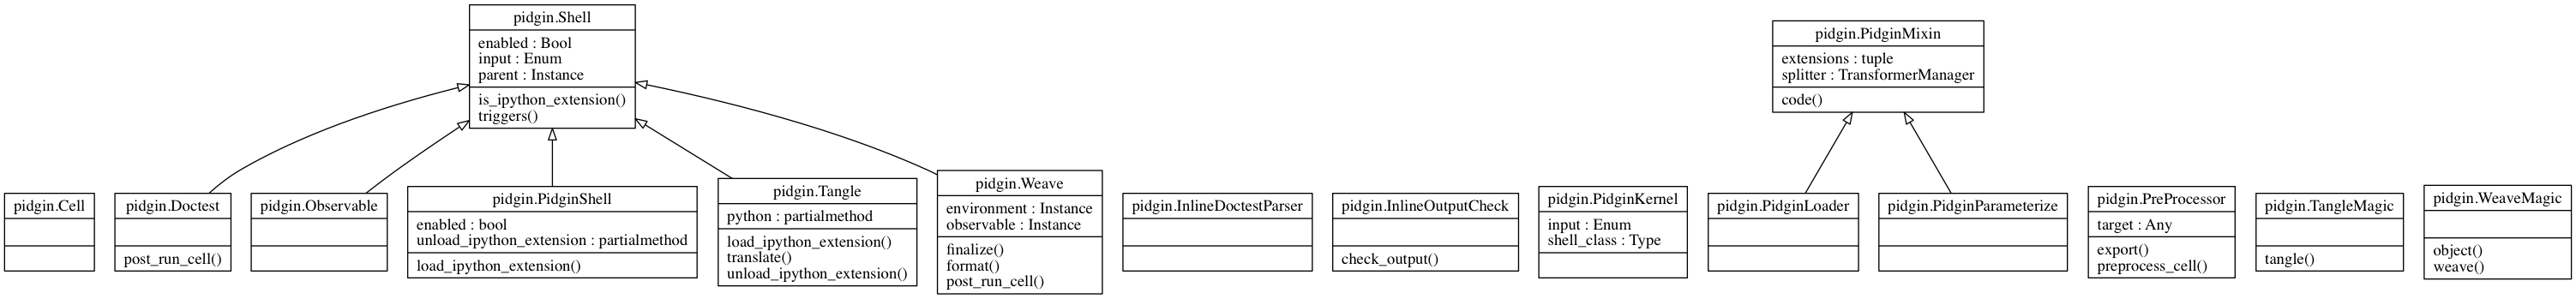

In [21]:
    if _run_as_interactive:
        !jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True pidgin.ipynb
        !isort pidgin.py
        !black pidgin.py
        !pyflakes pidgin.py && echo "🏋️‍♀️"
        !pyreverse -my -opng  -ppidgin pidgin
        IPython.display.display(IPython.display.Image('classes_pidgin.png', embed=True))